# Time-series prediction example

This notebook shows a simple way to predict time series data using a MLP neural network. 
The data is hourly weather data from Meteostat. 

For sake of simplicity and easy testing and debugging the code is implemented mostly as a script and only minimum amount of functions and classes are implemented. 

(c) Mikko Kursula 2021. MIT License. 

In [1]:
# General
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.pyplot as plt
import random

# Data source
import meteostat

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

# Get input data and define the training target
Data is queries using a target location. First the weather station is selected and then the data is loaded. 

In [2]:
stations = meteostat.Stations()
stations = stations.nearby(lat=61.4167, lon=23.5833)
station = stations.fetch(3)
station.head()

,name,country,region,wmo,icao,latitude,longitude,elevation,timezone,hourly_start,hourly_end,daily_start,daily_end,distance
id,,,,,,,,,,,,,,
02944,Tampere / Pirkkala,FI,<NA>,02944,EFTP,61.4167,23.5833,112.0,Europe/Helsinki,1906-01-01,2021-11-16,1979-11-01,NaT,0.000000
02763,Tampere Harmala / Lakalaiva,FI,<NA>,02763,<NA>,61.4667,23.7500,85.0,Europe/Helsinki,2008-01-15,2021-10-08,2008-01-17,NaT,10461.024472
02943,Tampere / Onkiniemi,FI,<NA>,02943,EFTA,61.5167,23.7500,98.0,Europe/Helsinki,1973-01-01,2021-10-08,2008-01-17,NaT,14214.060197


In [3]:
station_id = '02944'
start_dt = datetime(2000, 1, 1)
end_dt = datetime(2021, 11, 1)

# Get hourly data
raw_data = meteostat.Hourly(station_id, start_dt, end_dt)
raw_data = raw_data.fetch()
raw_data.to_parquet('dataset.parquet')

### Read the data from file 
Use this if the data has been obtained and stored earlier

In [4]:
raw_data = pd.read_parquet('dataset.parquet')

In [5]:
raw_data.sample(10)

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
2016-11-01 10:00:00,0.7,-3.6,73.0,NaN,NaN,120.0,11.2,NaN,1018.4,NaN,NaN
2008-04-05 23:00:00,2.0,0.1,87.0,NaN,NaN,180.0,7.6,NaN,NaN,NaN,NaN
2015-07-29 17:00:00,15.4,11.8,79.0,NaN,NaN,210.0,7.2,NaN,998.7,NaN,NaN
2008-10-25 19:00:00,7.8,5.1,83.0,NaN,NaN,210.0,18.0,NaN,1015.6,NaN,NaN
2010-05-03 15:00:00,8.9,-6.9,32.0,NaN,NaN,280.0,14.4,NaN,1017.6,NaN,NaN
2021-08-01 23:00:00,15.0,14.2,95.0,0.0,NaN,187.0,7.9,16.7,1000.1,NaN,4.0
2004-04-30 14:00:00,15.0,-2.9,29.0,NaN,NaN,290.0,16.6,NaN,NaN,NaN,NaN
2018-03-04 04:00:00,-20.3,-22.7,81.0,NaN,NaN,360.0,0.0,NaN,1011.6,NaN,NaN
2010-12-30 10:00:00,-12.8,-13.8,92.0,NaN,NaN,NaN,0.0,NaN,1013.0,NaN,NaN


# Data exploration and fixing

### Pick the columns to be used

In [6]:
columns = ['temp', 'dwpt', 'pres', 'prcp']

### Calculate continous datetime index and fill any gaps in data

In [7]:
new_index = pd.date_range(start_dt, end_dt, freq='1h')
dataset = pd.DataFrame(index=new_index)
dataset = pd.merge(dataset, raw_data[columns], left_index=True, right_index=True, how='left')

In [8]:
# prcp is sparse and will get zero filling
dataset['prcp'] = dataset['prcp'].fillna(0)

# Count number of missing values and fill the gaps 
for col in columns: 
    n_missing = pd.isnull(dataset[col]).sum()
    print('{}: missing {:0.3f}% of values'.format(col, n_missing / dataset.shape[0]))
    dataset[col] = dataset[col].fillna(method='ffill')

temp: missing 0.012% of values
dwpt: missing 0.016% of values
pres: missing 0.251% of values
prcp: missing 0.000% of values


### Inspect data
Correlation between temp and lagged signals is used to find if something in the signals can predict temp values. 
Especially correlation at positive lag values indicate predictive features. 
Autocorrelation, i.e. correlation between temp and lagged temp, gives information about the possibility of using temp values to predict the future temp values. 

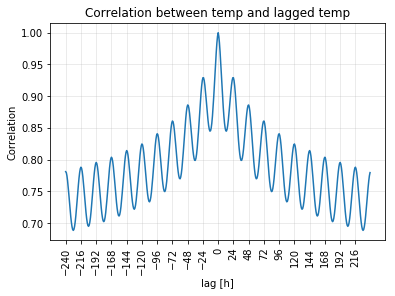

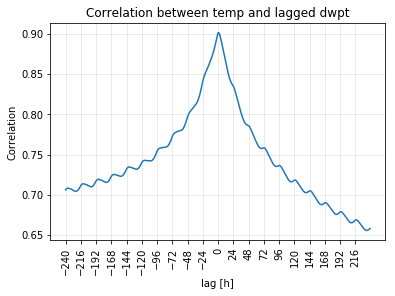

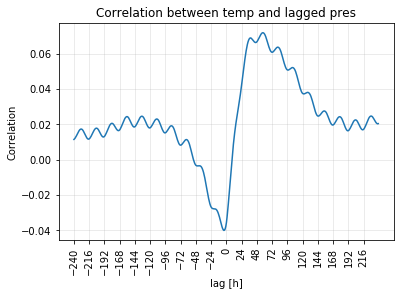

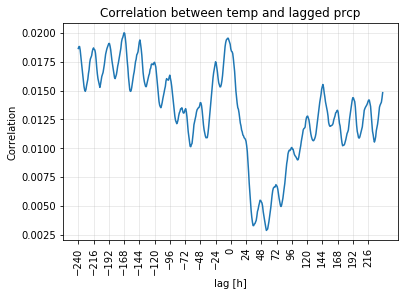

In [9]:
target_col = 'temp'
for col in columns: 
    corr_values = []
    x = []
    lags = np.arange(-240, 240)
    for lag in lags: 
        corr = dataset[target_col].corr(dataset[col].shift(lag))
        corr_values.append(corr)
        x.append(lag)

    plt.plot(x, corr_values)
    plt.ylabel('Correlation')
    plt.xlabel('lag [h]')
    plt.title('Correlation between {} and lagged {}'.format(target_col, col))
    plt.xticks(x[::24], rotation=90)
    plt.grid(alpha=0.3)
    plt.show()

### Plot some sequence samples

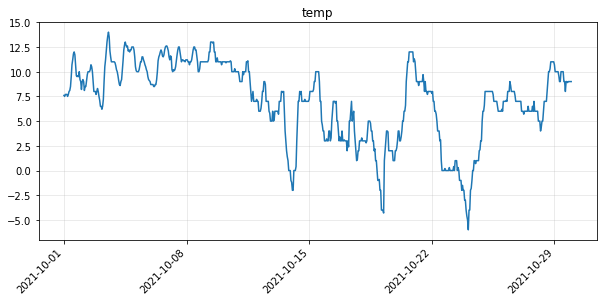

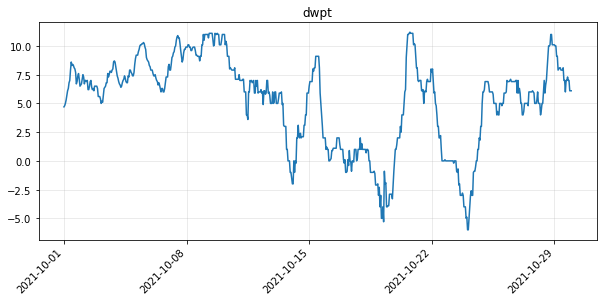

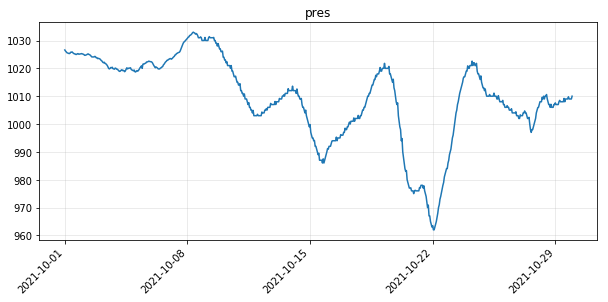

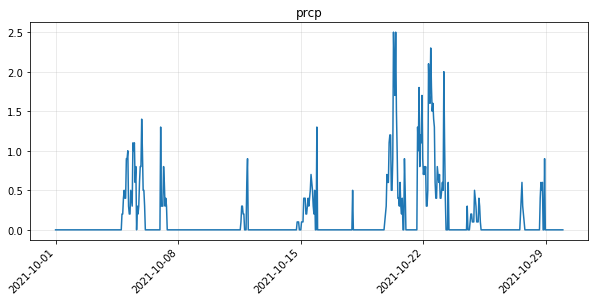

In [10]:
# Pick time range for the plot 
plot_start = datetime(2021, 10, 1)
plot_end = datetime(2021, 10, 30)

mask = (dataset.index >= plot_start) & (dataset.index < plot_end)
for col in columns: 
    plt.figure(figsize=(10, 4))
    plt.plot(dataset.loc[mask, col])
    plt.title(col)
    plt.xticks(rotation=45, ha='right')
    plt.grid(alpha=0.3)
    plt.show()

# Setup ML model parameters

In [11]:
params = dict(
    inputs = columns, 
    target = 'temp',
    input_len = 10 * 24,
    target_len = 3 * 24,
    stepping = 24, 
)

# Training dataset creation

In [12]:
class DataProcessing: 
    # Simple class for data preprocessing and postprocessing. 
    # Preprocessing will scale data to [0, 1] range. 
    # Postprocessing will scale data back to the original range. 
    
    def __init__(self, target : str, inputs : list): 
        self.min_values = {}
        self.max_values = {}
        self.target = target
        self.inputs = inputs

        
    def fit_params(self, dataset : pd.DataFrame): 
        columns = self.inputs
        if self.target not in columns: 
            columns.append(self.target)
            
        for col in columns: 
            self.min_values[col] = dataset[col].min()
            self.max_values[col] = dataset[col].max()

            
    def preprocess(self, dataset): 
        scaled = dataset.copy()
        for col in self.min_values.keys(): 
            scaled[col] = (scaled[col] - self.min_values[col]) / (self.max_values[col] - self.min_values[col])
        return scaled
        
        
    def postprocess(self, data, col): 
        data = data * (self.max_values[col] - self.min_values[col]) + self.min_values[col]
        return data
    
    
def create_training_samples(dataset : pd.DataFrame, params : dict):
    samples = []
    sample_idxs = []
    sample_count = int((dataset.shape[0] - params['input_len'] - params['target_len']) / params['stepping'])
    
    for sample_idx in range(sample_count): 
        in_start_i = sample_idx * params['stepping']
        in_start = dataset.index[in_start_i]
        
        in_end_i = in_start_i + params['input_len'] - 1
        in_end = dataset.index[in_end_i]

        target_start_i = in_end_i + 1
        target_start = dataset.index[target_start_i]

        target_end_i = target_start_i + params['target_len'] - 1
        target_end = dataset.index[target_end_i]

        in_values = dataset.loc[in_start : in_end, params['inputs']].values
        in_values = torch.from_numpy(in_values).float().permute(1, 0)
        target_values = dataset.loc[target_start : target_end, params['target']].values
        target_values = torch.from_numpy(target_values).float()
        samples.append([in_values, target_values])
        
        sample_idxs.append(target_start)
        
    return samples, sample_idxs

In [13]:
data_proc = DataProcessing(target=params['target'], inputs=params['inputs'])
data_proc.fit_params(dataset)
preproc = data_proc.preprocess(dataset)
samples, sample_idxs = create_training_samples(preproc, params)

np.random.seed(313)
np.random.shuffle(samples)
np.random.seed(313)
np.random.shuffle(sample_idxs)

train_test_ratio = 0.8 
batch_size = 64

split_idx = int(len(samples) * train_test_ratio)
train_loader = torch.utils.data.DataLoader(samples[:split_idx], batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(samples[split_idx:], batch_size=batch_size, shuffle=False)

# Setup neural network model

In [14]:
class Net(nn.Module):
    def __init__(self, params : dict):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(params['input_len'] * len(params['inputs']), 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, params['target_len'])
        
        
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        output = self.fc3(x)
        return output

In [15]:
def train(model, train_loader, optimizer, loss_func):
    losses = []
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return np.mean(losses)


def test(model, test_loader, loss_func):
    model.eval()
    losses = []
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            loss = loss_func(output, target)
            losses.append(loss.item())
    return np.mean(losses)

In [16]:
model = Net(params)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

epochs = 30

train_losses = []
test_losses = []

for epoch in range(epochs):
    train_loss = train(model, train_loader, optimizer, loss_func)
    test_loss = test(model, test_loader, loss_func)

    print('epoch: {:3}, train loss: {:0.5f}, test loss: {:0.5f}'.format(epoch, train_loss, test_loss))
    train_losses.append(train_loss)
    test_losses.append(test_loss)

epoch:   0, train loss: 0.07261, test loss: 0.00727
epoch:   1, train loss: 0.00657, test loss: 0.00602
epoch:   2, train loss: 0.00570, test loss: 0.00535
epoch:   3, train loss: 0.00524, test loss: 0.00491
epoch:   4, train loss: 0.00484, test loss: 0.00460
epoch:   5, train loss: 0.00453, test loss: 0.00421
epoch:   6, train loss: 0.00425, test loss: 0.00399
epoch:   7, train loss: 0.00413, test loss: 0.00410
epoch:   8, train loss: 0.00401, test loss: 0.00377
epoch:   9, train loss: 0.00394, test loss: 0.00370
epoch:  10, train loss: 0.00390, test loss: 0.00369
epoch:  11, train loss: 0.00385, test loss: 0.00367
epoch:  12, train loss: 0.00380, test loss: 0.00357
epoch:  13, train loss: 0.00377, test loss: 0.00353
epoch:  14, train loss: 0.00371, test loss: 0.00367
epoch:  15, train loss: 0.00372, test loss: 0.00350
epoch:  16, train loss: 0.00366, test loss: 0.00346
epoch:  17, train loss: 0.00362, test loss: 0.00346
epoch:  18, train loss: 0.00363, test loss: 0.00343
epoch:  19, 

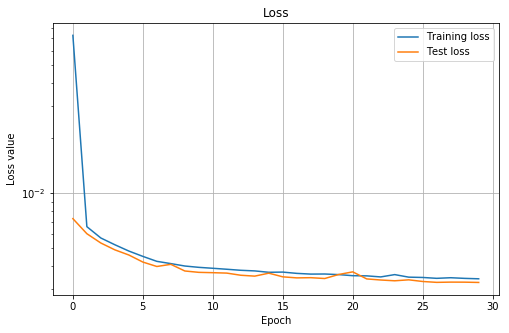

In [17]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

# Evaluate

In [18]:
# Chek the range of evaluation (test) sample indexes  
start = int(len(samples) * train_test_ratio)
end = len(samples)
print(start, end)

6369 7962


### Plot prediction samples

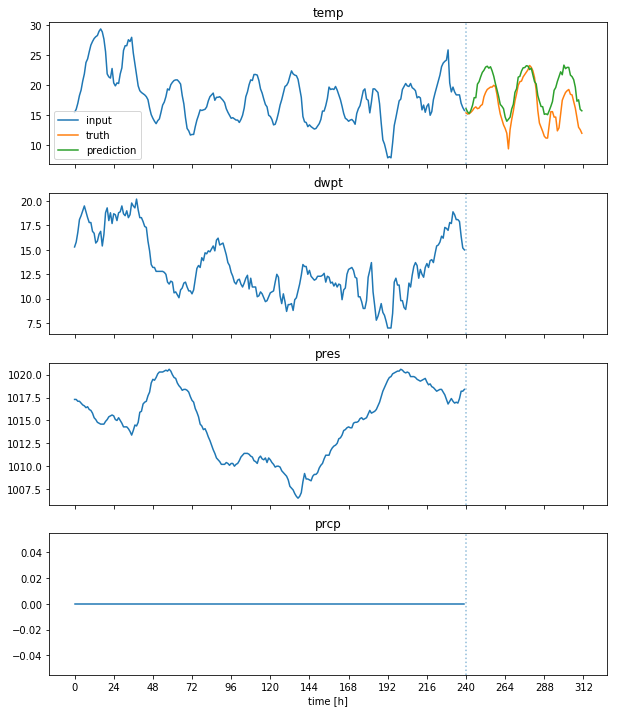

In [19]:
idx = 6464
model.eval()
pred = model(samples[idx][0].unsqueeze(0)).detach()[0]

pred_xvals = np.arange(params['input_len'], params['input_len'] + params['target_len'])
xticks = np.arange(0, params['input_len'] + params['target_len'] + 1, 24)

fig, axs_temp = plt.subplots(nrows=len(params['inputs']), ncols=1, sharex=True, figsize=(10, 3 * len(params['inputs'])))
if type(axs_temp) != np.ndarray: 
    axs_temp = [axs_temp]

axs = {}
for i, col in enumerate(params['inputs']):
    axs[col] = axs_temp[i]

# Inputs 
for i, col in enumerate(params['inputs']):
    ax = axs[col]
    orig_values = data_proc.postprocess(samples[idx][0][i, :], col) 
    ax.plot(orig_values, label='input')
    ax.set_title(col)
    ax.axvline(pred_xvals[0], ls=':', alpha=0.5)
    ax.set_xticks(xticks)

# Prediction 
ax = axs[params['target']]
orig_truth = data_proc.postprocess(samples[idx][1][:], params['target']) 
ax.plot(pred_xvals, orig_truth, label='truth')

orig_pred = data_proc.postprocess(pred, params['target']) 
ax.plot(pred_xvals, orig_pred, label='prediction')
ax.legend()

plt.xlabel('time [h]')
plt.show()

### Error figures

In [20]:
test_start_idx = int(len(samples) * train_test_ratio)

mae = []
dates = []
hourly_errors = []

model.eval()

for idx in range(test_start_idx, len(samples)):
    with torch.no_grad():
        pred = model(samples[idx][0].unsqueeze(0)).detach()[0]
    pred = data_proc.postprocess(pred, params['target']) 
    truth = data_proc.postprocess(samples[idx][1][:], params['target']) 
    
    error = np.mean(np.abs(pred.numpy() - truth.numpy()))
    mae.append(error)
    dates.append(sample_idxs[idx])
    
    hourly_errors.append(pred.numpy() - truth.numpy())

hourly_errors = np.array(hourly_errors)
err_df = pd.DataFrame(index=dates, data={'error' : mae})
err_df['month'] = err_df.index.month

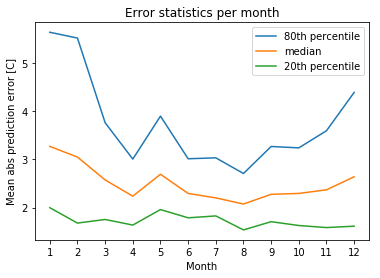

In [21]:
agg = err_df.groupby('month')['error'].quantile(0.8)
plt.plot(agg.index.values, agg.values, label='80th percentile')

agg = err_df.groupby('month')['error'].median()
plt.plot(agg.index.values, agg.values, label='median')

agg = err_df.groupby('month')['error'].quantile(0.2)
plt.plot(agg.index.values, agg.values, label='20th percentile')

plt.xticks(np.arange(1, 13))
plt.legend()
plt.title('Error statistics per month')
plt.ylabel('Mean abs prediction error [C]')
plt.xlabel('Month')
plt.show()

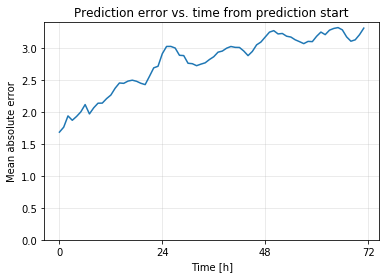

In [22]:
plt.plot(np.mean(np.abs(hourly_errors), axis=0))
plt.grid(alpha=0.3)
plt.title('Prediction error vs. time from prediction start')
plt.ylabel('Mean absolute error')
plt.xlabel('Time [h]')
plt.xticks(np.arange(0, params['target_len'] + 1, 24))
plt.ylim(0)
plt.show()

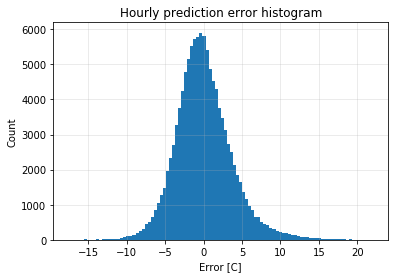

In [23]:
plt.hist(hourly_errors.flatten(), bins=100)
plt.grid(alpha=0.3)
plt.title('Hourly prediction error histogram')
plt.ylabel('Count')
plt.xlabel('Error [C]')
plt.show()